In [ ]:
#matplotlib 한글깨짐방지
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf
#xls 읽기 위해
!pip install xlrd==1.2.0 

In [ ]:
from google.colab import drive
drive.mount('/content/drive') 

import os
import tqdm

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

from bokeh.layouts import column, row
from bokeh.models import CustomJS, Slider
from bokeh.plotting import ColumnDataSource, figure, show

import plotly.graph_objects as go

from sklearn.linear_model import LinearRegression

# DACON - 6조

## 주제  
**<font color=#5F71F7> '서울시 지하철 우대권 혜택 축소에 따른 효과 분석 : 교통 혼잡 개선과 운임 기회비용 측면을 중심으로' </font>**

## 목차  
###  1. 서론
###  2. 본론
###  2-1. 현황 분석 및 현재 문제 해결의 필요성
###  2-2. 각 대안의 제시 및 검증, 예상 효과 분석
###  3. 결론
###  4. 참고 문헌 (Reference)
---

## 서론
 현재 고령화 인구가 지속적으로 증가<sup>[1](https://www.dbpia.co.kr/journal/articleDetail?nodeId=NODE07058589)</sup>함에 따라 철도 무임승차 대상자 역시 증가하고 있다<sup>[2](https://www.dbpia.co.kr/Journal/articleDetail?nodeId=NODE07064975)</sup>. 따라서 관련 기관의 무임 손실비용이 급격하게 커지고 있다.<sup>[3](https://www.etoday.co.kr/news/view/2171664)</sup> 서울시에서 무임수송에 대한 비용 일부를 부담<sup>[4](https://www.dbpia.co.kr/Journal/articleDetail?nodeId=NODE11044573)</sup>하기 때문에, 해당 문제는 서울시의 재정적인 부담과도 이어진다. 이 문제를 해결하기 위한 대안들이 여러 차례 연구가 되고 있는 중이다.<sup>[5](https://www.dbpia.co.kr/journal/articleDetail?nodeId=NODE09217073), [6](https://www.kci.go.kr/kciportal/ci/sereArticleSearch/ciSereArtiView.kci?sereArticleSearchBean.artiId=ART002039001)</sup> 이 대안들 중에서 몇 가지 방법을 재정적인 측면에서 효율성을 재고해보고자 한다.

## 본론  
  1. 기존 데이터 탐색 및 분석 결과
   - 전자교통시스템의 발달로 승차자와 하차자에 관련한 비교적 정확한 데이터를 다수 발견할수 있었다. 
   - 하지만 이러한 데이터의 경우 데이터 마스킹, 가명처리, 총계처리, 데이터 범주화 등의 개인정보 식별 방지 기술이 적용되어 있어, 승하차자의 정보에 대한 추적과 개인 표적화를 할 수 있는 데이터는 없었다.
   - 이러한 이유로, 우대권 이용자 개인 보다는 더 큰 이용 패턴과 흐름에 집중하기로 결정하였다.
   - 연령별, 시간별, 성비별 등 판단해야 할 요소가 많았기 때문에 각종 시각화 자료와 표를 활용, 유의미한 형태를 보이는 요소를 선별하기로 하였다.
   - 대안은 크게 교통 혼잡도 개선 효과, 운임 기회비용의 감소규모, 대안별 선호도 세가지 요소에 의해 평가하기로 하였다.

  2. 분석해볼 대안
   - 우대권 적용 연령 70세로 상향 조정
      - 서울시 거주 인구 데이터 활용, 65세~70세 인구 비율 파악 (2017년~2021년 서울시 나이별 인구 비율 월단위/연단위로 파악 후 65~70세 인구 비율을 어떻게 설정할 지 생각할 예정)
      - 2022년 이후 무임승차 인원 예상 (2020년 이전의 데이터 활용해 회귀 계수 계산 후, 2022년 무임승차 인원 데이터로 y절편 계산 후 Linear Regression 적용해서 예측; 2020~2022는 코로나 때문에 인구 변동폭이 크기 때문, 2022년 코로나 이후 안정화된 상태라고 가정 후, 2020년까지의 회귀 계수 적용으로 미래 인구 수 예상)

      - 위 자료를 토대로, 위 대안을 적용했을 시 2023년 무임승차 사용 인원 및 요금 계산 예정
   
   - 상시 운임에 할인율 적용
      - 논문에 나와 있는 survey 활용 (65세 이상 노인분들이 무임승차 혜택을 제한받을 시, 철도를 계속 사용할 것인 지 사용하지 않을 것인 지를 조사한 자료가 있음)
      - 할인율에 따른 인구변화 추정 식; 할인율을 P%라고 산정했을 시,
        철도 이용 인구 : 현 무임승차 인원 대비 45 + 55*(100-P)/100 (%)
        (조사 내용 - 할인해도 철도 이용 : 45% / 할인 시 다른 수단 이용 or 탑승 줄임 : 55%)

   - 출퇴근시간 동안 우대권 할인 혜택 제외
      - 년도별/월별 시간에 따른 무임승차 인원 비율 파악 (ex. 2020년도 8월 기준, 무임승차 이용 인원 중 07시~08시에 사용하는 인원의 비율 - 15%, 08시~09시에 사용하는 인원 비율 - 10% , ...)
      - 위 변화 계산 또한 논문에 나와 있는 survey를 활용할 예정 (무임승차자 대상 인적특성별 이용목적 조사자료) / 경제활동 참여 인원만 출퇴근 시간 이용한다고 가정, 10%로 산정할 예정
      - 각 시간의 비율에 해당하는 무임승차 인원 중, 경제활동 인원 비율을 제외한 후, 무임승차 인원의 변화 계산

   - 특정 호선에 대한 할인율 차등 적용
   
  
  3. 대안의 결과 분석 방안
   - 교통 혼잡도 개선은 출퇴근 시간대의 혼잡한 상위역 대상으로 감소될 이용자 예측 수를 바탕으로 평가.
   - 운임 기회비용 규모는 감소할 이용 건당 현재 지하철 이용 최소요금 1250원씩 계산.
   - 대안별 선호도는 다른 논문에서 인용한 선호도 설문조사를 바탕으로 평가<sup>[7](http://dl.nanet.go.kr/law/SearchDetailView.do?cn=NONB1201420898)</sup>

  4. 결과 해석 방침
   - 하나의 대안을 선정 해주는게 아니라 각 요소 별로 순위를 나누거나 종합적인 평가를 하고 선택을 해주지 않는 방향으로 작성할 예정입니다.

### 현황 분석 및 현재 문제 해결의 필요성

  1. 우대권 사용 인구 중 노년층 비율 분석
  2. 서울시 지하철 이용 현황 분석
    *   서울시 지하철역 중 출퇴근 시간대 총 승하차자, 우대권 이용자 수 상위 10개역
    *   서울시 지하철 아침/저녁 승하차 전체 승객수  집계
    *   서울시 지하철 아침/저녁 승하차 우대권 승객수 집계
    *   서울시 지하철 총 우대권 사용수 집계
    *   서울시 지하철 월 평균 우대권 승객 수 상위 10개역
    *   서울시 지하철 우대권 승객 비율 상위 10개역
  3. 서울시 대중교통 환승 이용패턴 분석
  4. 서울시 시간 별 지하철 이용 현황 분포도 기반 분석
    *   서울시 아침/오후/저녁 시간대 승하차 전체 승객수 분포도
    *   서울시 아침/오후/저녁 시간대 승하차 일반 승객수 분포도
    *   서울시 아침/오후/저녁 시간대 승하차 우대권 승객수 분포도
    *   서울시 계절별 승하차 우대권 승객수 분포도
  5. 서울시 연도별 노인 거주 현황 분포도
  6.
  7.
  8.

###1. 우대권 사용 인구 중 노년층 비율 분석

In [ ]:
dirr = '/content/drive/MyDrive/DACON6/지하철 이용 정보/서울교통공사 무임수송, 우대권 관련/역별_무임수송_실적(1992년-2016년).csv'
df_rate = pd.read_csv(dirr, encoding='cp949', thousands = ',' )
df_rate['노년층 비율'] = df_rate['노인(천명)'].astype('float')/(df_rate['계(무임수송인원)'].astype('float'))*100
df_rate = df_rate[['연도', '계(무임수송인원)', '노인(천명)', '장애인(천명)','노년층 비율']][-8:]

sns.set(rc={"figure.figsize":(10, 5)})
plt.rc('font', family='NanumBarunGothic') 
x=df['연도']
y=df['노년층 비율']
sns.barplot(x=x,y=y,palette="mako").set(title='우대권 이용자 중 노년층 비율(%)')
plt.xticks(rotation=45)
for i, v in enumerate(df_rate.index):
    plt.text(v, y[i], '{:,.0f}'.format(y[i]),                
             fontsize = 9, 
             color='black',
             horizontalalignment='center', 
             verticalalignment='bottom')

plt.show()

### 2. 서울시 지하철 이용 현황 분석


####서울시 지하철역 중 출퇴근 시간대[출처추가. 아침: 7시-9시, 저녁 : 18시-20시] 총 승하차자, 우대권 이용자 수 상위 10개역.

In [ ]:
def read_df(y, m, sheet=2): #sheet 2는 월별 무임유임 승하차 데이터, sheet3은 일별시간별 승하차데이터
  rootdir = '/content/drive/MyDrive/DACON6/지하철 이용 정보/교통카드 통계자료' #승하차 데이터 루트 경로

  sub_dirs = {} #sub_dirs[year][month]로 해당 월의 xls 파일경로를 가져올 수 있도록 딕셔너리 만듦.
  for year in os.listdir(rootdir):
    sub_sub_dirs = {}
    for month in os.listdir(os.path.join(rootdir, year)):
      sub_sub_dirs[int(month.split(' ')[1][:2])] = os.path.join(rootdir, year, month)
    sub_dirs[int(year)] = sub_sub_dirs

  df = pd.read_excel(sub_dirs[y][m], sheet_name=sheet, thousands=',')

  if sheet==2:
    df = df.drop(columns=['호선명', '역ID', '작업일시', '사용월'])
    df = df.groupby(by='지하철역').sum()
    df['지하철역'] = df.index
    df.index = list(range(len(df)))
  if sheet==3:
    df = df.iloc[1:, 3:-1]
    c = ['지하철역']
    for i in range(24):
      c.append(f'{(i+3)%24}시승차')
      c.append(f'{(i+3)%24}시하차')
    df.columns = c
    temp = df['지하철역']
    df = df[df.columns[1:]].astype('int')
    df['지하철역'] = temp
    df = df.groupby(by='지하철역').sum()
    df['지하철역'] = df.index
    df.index = list(range(len(df)))
  return df


####서울시 지하철 아침/저녁 승하차 전체 승객 수 집계

In [ ]:
#시간대별 전체 승하차
ampm_total = read_df(2022, 5, 3)

time_dict = {'아침승차':['7시승차', '8시승차'], '아침하차':['7시하차', '8시하차'], '점심승차':['14시승차','15시승차'], '점심하차':['14시하차','15시하차'], '저녁승차':['18시승차', '19시승차'], '저녁하차':['18시하차', '19시하차']}
for s in ['아침승차', '아침하차', '점심승차', '점심하차', '저녁승차', '저녁하차']:
  ampm_total[s] = ampm_total[time_dict[s]].mean(axis=1)

#아침승하차, 저녁승하차  
total_ampm=ampm_total[['아침승차','아침하차','저녁승차','저녁하차']].astype(int)
total_ampm.insert(0,'지하철역',ampm_total['지하철역'])
total_ampm['아침승하차']=total_ampm['아침승차']+total_ampm['아침하차']
total_ampm['저녁승하차']=total_ampm['저녁승차']+total_ampm['저녁하차']

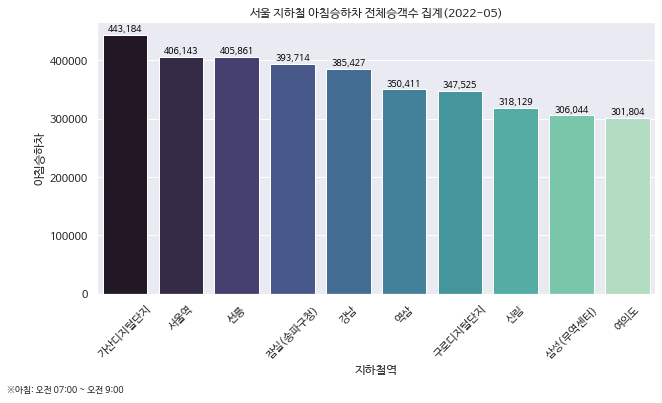

In [ ]:
#아침승하차, 저녁승하차 합계만
total_ampm = total_ampm.drop(columns=['아침승차', '아침하차', '저녁승차', '저녁하차'])
#아침승하차 순위
total_am=(total_ampm
        .drop(columns=['저녁승하차'])
        .sort_values('아침승하차',ascending=False)
        .reset_index(drop=True)
        .iloc[:10]
        )
sns.set(rc={"figure.figsize":(10, 5)})
plt.rc('font', family='NanumBarunGothic') 
x=total_am['지하철역']
y=total_am['아침승하차']
sns.barplot(x=x,y=y,palette="mako").set(title='서울 지하철 아침승하차 전체승객수 집계(2022-05)')
plt.xticks(rotation=45)
plt.figtext(0, -0.15, '※아침: 오전 07:00 ~ 오전 9:00', fontSize=9)
#수치값 표시
for i, v in enumerate(total_am.index):
    plt.text(v, y[i], '{:,.0f}'.format(y[i]),                
             fontsize = 9, 
             color='black',
             horizontalalignment='center', 
             verticalalignment='bottom')

plt.show()

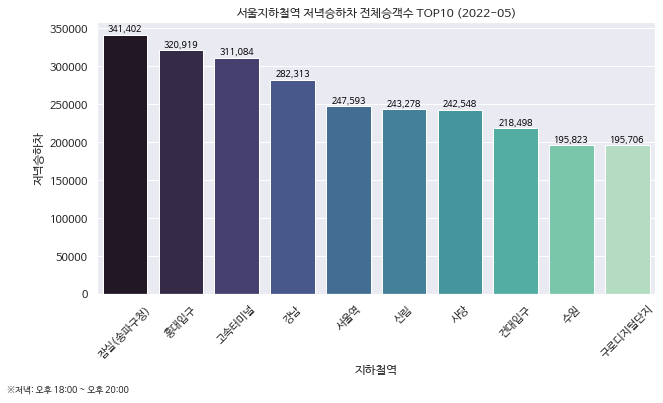

In [ ]:
#저녁승하차 순위
total_pm=(total_ampm
        .drop(columns=['아침승하차'])
        .sort_values('저녁승하차',ascending=False)
        .reset_index(drop=True)
        .iloc[:10]
        )
sns.set(rc={"figure.figsize":(10, 5)})
plt.rc('font', family='NanumBarunGothic') 
x=total_pm['지하철역']
y=total_pm['저녁승하차']
sns.barplot(x=x,y=y,palette="mako").set(title='서울지하철역 저녁승하차 전체승객수 TOP10 (2022-05)')
plt.figtext(0, -0.15, '※저녁: 오후 18:00 ~ 오후 20:00', fontSize=9)
plt.xticks(rotation=45)
#수치값 표시
for i, v in enumerate(total_pm.index):
    plt.text(v, y[i], '{:,.0f}'.format(y[i]),                
             fontsize = 9, 
             color='black',
             horizontalalignment='center', 
             verticalalignment='bottom')
plt.show()

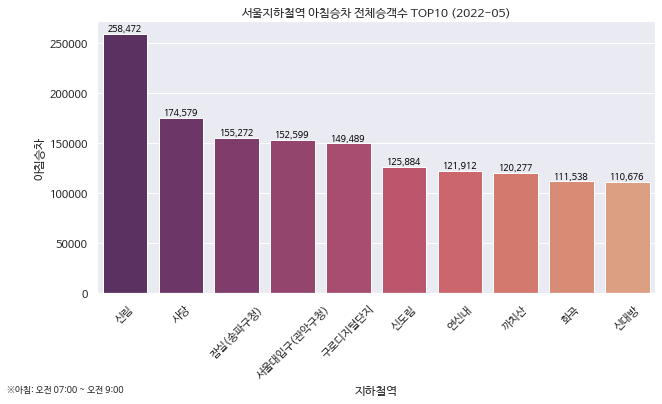

In [ ]:
#아침승차
total_am_on=(ampm_total[['지하철역','아침승차']]
        .sort_values('아침승차',ascending=False)
        .reset_index(drop=True)
        .iloc[:10]
        )
total_am_on['아침승차']=total_am_on['아침승차'].astype(int)
sns.set(rc={"figure.figsize":(10, 5)})
plt.rc('font', family='NanumBarunGothic')
x=total_am_on['지하철역']
y=total_am_on['아침승차']

#색상선택
palette = sns.color_palette("flare",n_colors=10)
palette.reverse() 
p=sns.barplot(x=x,y=y,data=total_am_on,palette=palette).set(title='서울지하철역 아침승차 전체승객수 TOP10 (2022-05)')
plt.figtext(0, -0.15, '※아침: 오전 07:00 ~ 오전 9:00', fontSize=9)
plt.xticks(rotation=45)
#수치값 표시
for i, v in enumerate(total_am_on.index):
    plt.text(v, y[i],'{:,.0f}'.format(y[i]),                
             fontsize = 9, 
             color='black',
             horizontalalignment='center', 
             verticalalignment='bottom')
plt.show()


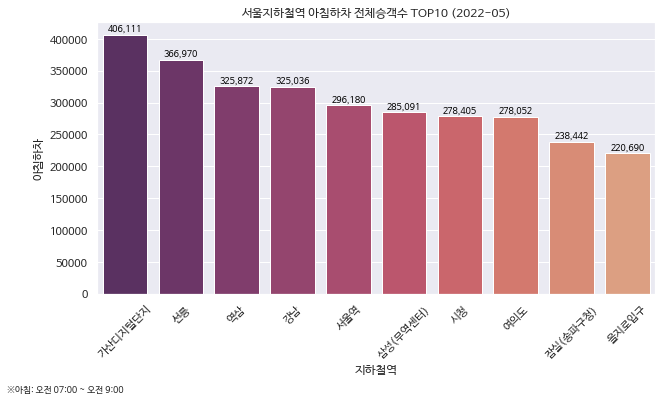

In [ ]:
#아침하차
total_am_off=(ampm_total[['지하철역','아침하차']]
        .sort_values('아침하차',ascending=False)
        .reset_index(drop=True)
        .iloc[:10]
        )
total_am_off['아침하차']=total_am_off['아침하차'].astype(int)
sns.set(rc={"figure.figsize":(10, 5)})
plt.rc('font', family='NanumBarunGothic') 
x=total_am_off['지하철역']
y=total_am_off['아침하차']

#색상선택
palette = sns.color_palette("flare",n_colors=10)
palette.reverse() 
sns.barplot(x=x,y=y,data=total_am_on,palette=palette).set(title='서울지하철역 아침하차 전체승객수 TOP10 (2022-05)')
plt.figtext(0, -0.15, '※아침: 오전 07:00 ~ 오전 9:00', fontSize=9)
plt.xticks(rotation=45)

#수치값 표시
for i, v in enumerate(total_am_off.index):
    plt.text(v, y[i],'{:,.0f}'.format(y[i]),                
             fontsize = 9, 
             color='black',
             horizontalalignment='center', 
             verticalalignment='bottom')
plt.show()

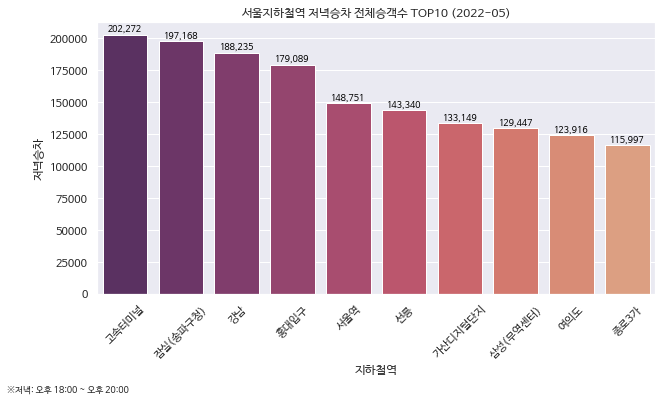

In [ ]:
#저녁승차
total_pm_on=(ampm_total[['지하철역','저녁승차']]
        .sort_values('저녁승차',ascending=False)
        .reset_index(drop=True)
        .iloc[:10]
        )
total_pm_on['저녁승차']=total_pm_on['저녁승차'].astype(int)
sns.set(rc={"figure.figsize":(10, 5)})
plt.rc('font', family='NanumBarunGothic') 
x=total_pm_on['지하철역']
y=total_pm_on['저녁승차']

#색상선택
palette = sns.color_palette("flare",n_colors=10)
palette.reverse() 
sns.barplot(x=x,y=y,data=total_am_on,palette=palette).set(title='서울지하철역 저녁승차 전체승객수 TOP10 (2022-05)')
plt.figtext(0, -0.15, '※저녁: 오후 18:00 ~ 오후 20:00', fontSize=9)
plt.xticks(rotation=45)
#수치값 추가
for i, v in enumerate(total_pm_on.index):
    plt.text(v, y[i], '{:,.0f}'.format(y[i]),                 
             fontsize = 9, 
             color='black',
             horizontalalignment='center', 
             verticalalignment='bottom')   
plt.show()

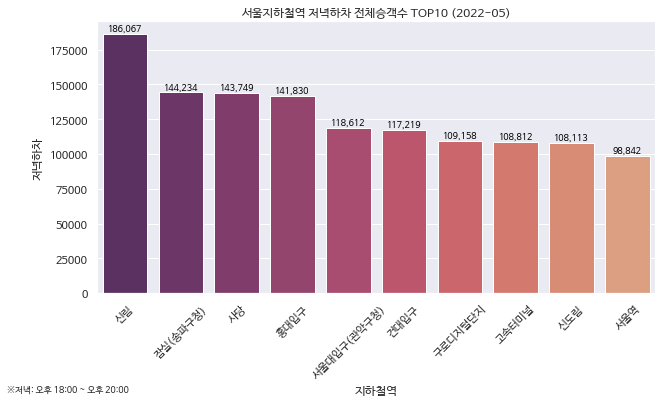

In [ ]:
total_pm_off=(ampm_total[['지하철역','저녁하차']]
        .sort_values('저녁하차',ascending=False)
        .reset_index(drop=True)
        .iloc[:10]
        )
total_pm_off['저녁하차']=total_pm_off['저녁하차'].astype(int)
sns.set(rc={"figure.figsize":(10, 5)})
plt.rc('font', family='NanumBarunGothic') 
x=total_pm_off['지하철역']
y=total_pm_off['저녁하차']

#색상선택
palette = sns.color_palette("flare",n_colors=10)
palette.reverse() 
sns.barplot(x=x,y=y,data=total_am_on,palette=palette).set(title='서울지하철역 저녁하차 전체승객수 TOP10 (2022-05)')
plt.figtext(0, -0.15, '※저녁: 오후 18:00 ~ 오후 20:00', fontSize=9)
#텍스트 회전
plt.xticks(rotation=45)
#수치값 추가
for i, v in enumerate(total_pm_on.index):
    plt.text(v, y[i],'{:,.0f}'.format(y[i]),                 
             fontsize = 9, 
             color='black',
             horizontalalignment='center', 
             verticalalignment='bottom')  
plt.show()

####서울시 지하철 아침/저녁 승하차 우대권 승객 수 집계

In [ ]:
senior_ampm=pd.read_csv('/content/drive/MyDrive/DACON6/지하철 이용 정보/서울교통공사_역별 일별 시간대별 노인 승하차인원 정보_20220531.csv',encoding='cp949')
senior_ampm.head()

In [ ]:
#월단위로 추출하기 위해 date 타입으로 바꿔줌
senior_ampm['일자'] = pd.to_datetime(senior_ampm['일자'])
#5월 데이터 추출
query_month = 5 
senior_ampm_f = senior_ampm.query('일자.dt.month == @query_month')
#아침승하차, 저녁승하차 합계
senior_ampm_f =senior_ampm_f[['역명','07시-08시','08시-09시','18시-19시','19시-20시']]
senior_ampm_f= senior_ampm_f.groupby(senior_ampm_f['역명']).sum()
senior_ampm_f.reset_index(level=['역명'], inplace = True)
senior_ampm_f['아침승하차']=senior_ampm_f['07시-08시']+senior_ampm_f['08시-09시']
senior_ampm_f['저녁승하차']=senior_ampm_f['18시-19시']+senior_ampm_f['19시-20시']
senior_ampm_f=senior_ampm_f.drop(columns=['07시-08시','08시-09시','18시-19시','19시-20시'])

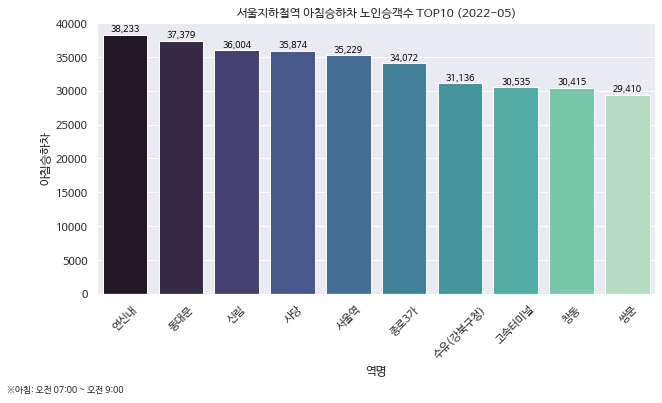

In [ ]:
#노인 아침승하차
senior_am=(senior_ampm_f
        .drop(columns=['저녁승하차'])
        .sort_values('아침승하차',ascending=False)
        .iloc[:10]
        )
senior_am['아침승하차']=senior_am['아침승하차'].astype(int)
senior_am=senior_am.reset_index(drop=True)

sns.set(rc={"figure.figsize":(10, 5)})
plt.rc('font', family='NanumBarunGothic') 
x=senior_am['역명']
y=senior_am['아침승하차']
sns.barplot(x=x,y=y,palette="mako").set(title='서울지하철역 아침승하차 노인승객수 TOP10 (2022-05)')
plt.figtext(0, -0.15, '※아침: 오전 07:00 ~ 오전 9:00', fontSize=9)

#텍스트 회전
plt.xticks(rotation=45)

#수치값 추가
for i, v in enumerate(senior_am.index):
    plt.text(v, y[i],'{:,.0f}'.format(y[i]),                 
             fontsize = 9, 
             color='black',
             horizontalalignment='center', 
             verticalalignment='bottom') 

plt.show()

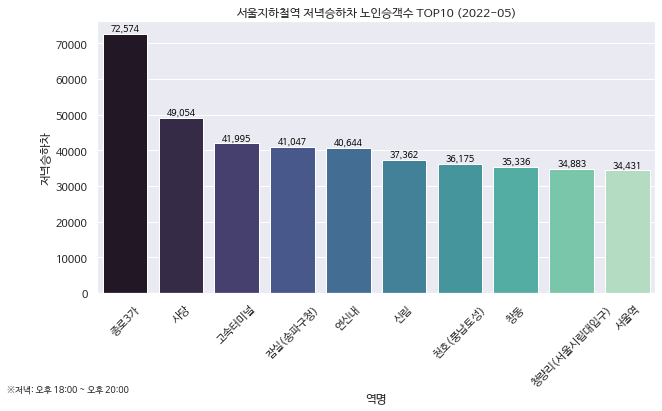

In [ ]:
#노인 저녁 승하차
senior_pm=(senior_ampm_f
        .drop(columns=['아침승하차'])
        .sort_values('저녁승하차',ascending=False)
        .iloc[:10]
        )
senior_pm['저녁승하차']=senior_pm['저녁승하차'].astype(int)
senior_pm=senior_pm.reset_index(drop=True)
senior_pm
sns.set(rc={"figure.figsize":(10, 5)})
plt.rc('font', family='NanumBarunGothic') 
x=senior_pm['역명']
y=senior_pm['저녁승하차']
sns.barplot(x=x,y=y,palette="mako").set(title='서울지하철역 저녁승하차 노인승객수 TOP10 (2022-05)')
plt.figtext(0, -0.15, '※저녁: 오후 18:00 ~ 오후 20:00', fontSize=9)
#텍스트 회전
plt.xticks(rotation=45)
#수치값 추가
for i, v in enumerate(senior_pm.index):
    plt.text(v, y[i], '{:,.0f}'.format(y[i]),                 
             fontsize = 9, 
             color='black',
             horizontalalignment='center', 
             verticalalignment='bottom') 

plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


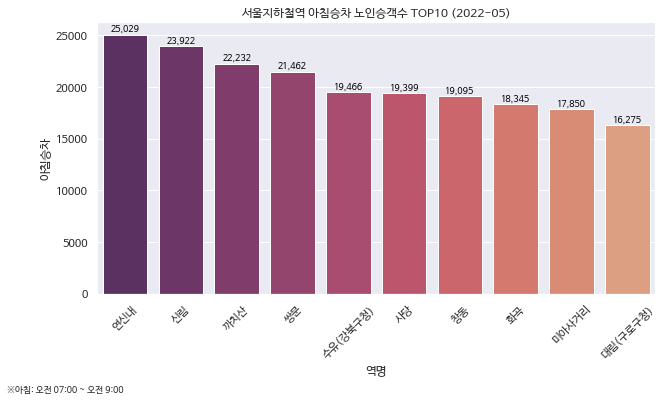

In [ ]:
#5월 데이터 추출
query_month = 5 
senior_onoff = senior_ampm.query('일자.dt.month == @query_month')

#승차데이터만 추출
senior_on=senior_onoff[senior_onoff['구분']=='합계 : 승차']

#아침승차
senior_am_on =senior_on[['역명','07시-08시','08시-09시']]
senior_am_on['아침승차']=senior_am_on['07시-08시']+senior_am_on['08시-09시']
senior_am_on=senior_am_on.drop(columns=['07시-08시','08시-09시'])
senior_am_on= senior_am_on.groupby(senior_am_on['역명']).sum()

#아침승차 top10
senior_am_on=(senior_am_on
        .sort_values('아침승차',ascending=False)
        .reset_index()
        .iloc[:10]
        )
senior_am_on['아침승차']=senior_am_on['아침승차'].astype(int)

#시각화
sns.set(rc={"figure.figsize":(10, 5)})
plt.rc('font', family='NanumBarunGothic')
x=senior_am_on['역명']
y=senior_am_on['아침승차']

#색상선택
palette = sns.color_palette("flare",n_colors=10)
palette.reverse() 
p=sns.barplot(x=x,y=y,data=senior_am_on,palette=palette).set(title='서울지하철역 아침승차 노인승객수 TOP10 (2022-05)')
plt.figtext(0, -0.15, '※아침: 오전 07:00 ~ 오전 9:00', fontSize=9)
#텍스트 회전
plt.xticks(rotation=45)
#수치값 표시
for i, v in enumerate(senior_am_on.index):
    plt.text(v, y[i],'{:,.0f}'.format(y[i]),                
             fontsize = 9, 
             color='black',
             horizontalalignment='center', 
             verticalalignment='bottom')
plt.show()


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


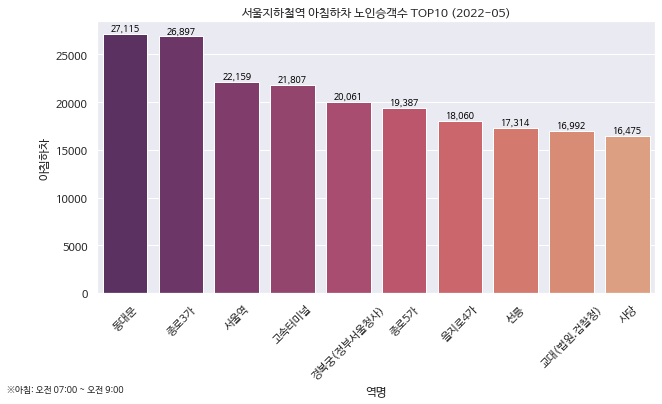

In [ ]:
#하차데이터만 추출
senior_off=senior_onoff[senior_onoff['구분']=='합계 : 하차']

#아침하차
senior_am_off =senior_off[['역명','07시-08시','08시-09시']]
senior_am_off['아침하차']=senior_am_off['07시-08시']+senior_am_off['08시-09시']
senior_am_off=senior_am_off.drop(columns=['07시-08시','08시-09시'])
senior_am_off= senior_am_off.groupby(senior_am_off['역명']).sum()

#아침하차 top10
senior_am_off=(senior_am_off
        .sort_values('아침하차',ascending=False)
        .reset_index()
        .iloc[:10]
        )
senior_am_off['아침하차']=senior_am_off['아침하차'].astype(int)

#시각화
sns.set(rc={"figure.figsize":(10, 5)})
plt.rc('font', family='NanumBarunGothic')
x=senior_am_off['역명']
y=senior_am_off['아침하차']

#색상선택
palette = sns.color_palette("flare",n_colors=10)
palette.reverse() 
p=sns.barplot(x=x,y=y,data=senior_am_off,palette=palette).set(title='서울지하철역 아침하차 노인승객수 TOP10 (2022-05)')
plt.figtext(0, -0.15, '※아침: 오전 07:00 ~ 오전 9:00', fontSize=9)
#텍스트 회전
plt.xticks(rotation=45)
#수치값 표시
for i, v in enumerate(senior_am_off.index):
    plt.text(v, y[i], '{:,.0f}'.format(y[i]),                
             fontsize = 9, 
             color='black',
             horizontalalignment='center', 
             verticalalignment='bottom')
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


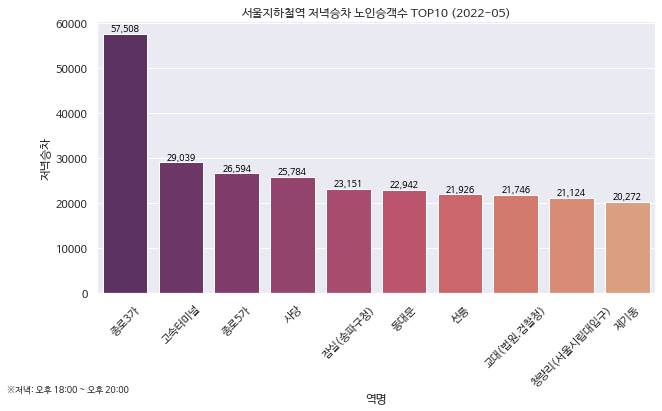

In [ ]:
#저녁승차
senior_pm_on =senior_on[['역명','18시-19시','19시-20시']]
senior_pm_on['저녁승차']=senior_pm_on['18시-19시']+senior_pm_on['19시-20시']
senior_pm_on=senior_pm_on.drop(columns=['18시-19시','19시-20시'])
senior_pm_on= senior_pm_on.groupby(senior_pm_on['역명']).sum()

#아침승차 top10
senior_pm_on=(senior_pm_on
        .sort_values('저녁승차',ascending=False)
        .reset_index()
        .iloc[:10]
        )
senior_pm_on['저녁승차']=senior_pm_on['저녁승차'].astype(int)

#시각화
sns.set(rc={"figure.figsize":(10, 5)})
plt.rc('font', family='NanumBarunGothic')
x=senior_pm_on['역명']
y=senior_pm_on['저녁승차']

#색상선택
palette = sns.color_palette("flare",n_colors=10)
palette.reverse() 
p=sns.barplot(x=x,y=y,data=senior_pm_on,palette=palette).set(title='서울지하철역 저녁승차 노인승객수 TOP10 (2022-05)')
plt.figtext(0, -0.15, '※저녁: 오후 18:00 ~ 오후 20:00', fontSize=9)
#텍스트 회전
plt.xticks(rotation=45)
#수치값 표시
for i, v in enumerate(senior_pm_on.index):
    plt.text(v, y[i], '{:,.0f}'.format(y[i]),                
             fontsize = 9, 
             color='black',
             horizontalalignment='center', 
             verticalalignment='bottom')
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


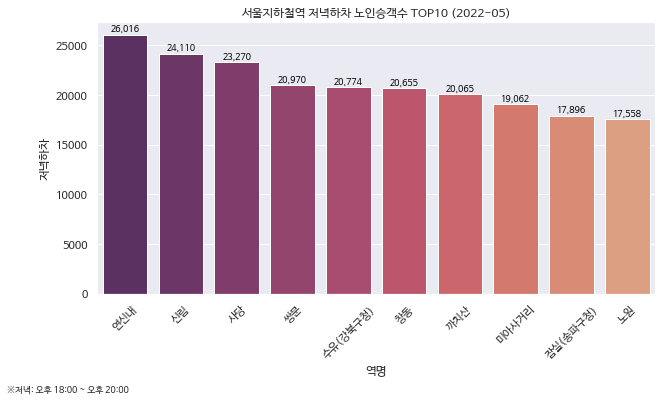

In [ ]:
#저녁하차
senior_pm_off =senior_off[['역명','18시-19시','19시-20시']]
senior_pm_off['저녁하차']=senior_pm_off['18시-19시']+senior_pm_off['19시-20시']
senior_pm_off=senior_pm_off.drop(columns=['18시-19시','19시-20시'])
senior_pm_off= senior_pm_off.groupby(senior_pm_off['역명']).sum()

#저녁하차 top10
senior_pm_off=(senior_pm_off
        .sort_values('저녁하차',ascending=False)
        .reset_index()
        .iloc[:10]
        )
senior_pm_off['저녁하차']=senior_pm_off['저녁하차'].astype(int)

#시각화
sns.set(rc={"figure.figsize":(10, 5)})
plt.rc('font', family='NanumBarunGothic')
x=senior_pm_off['역명']
y=senior_pm_off['저녁하차']

#색상선택
palette = sns.color_palette("flare",n_colors=10)
palette.reverse() 
p=sns.barplot(x=x,y=y,data=senior_pm_off,palette=palette).set(title='서울지하철역 저녁하차 노인승객수 TOP10 (2022-05)')
plt.figtext(0, -0.15, '※저녁: 오후 18:00 ~ 오후 20:00', fontSize=9)
#텍스트회전
plt.xticks(rotation=45)


#수치값 표시
for i, v in enumerate(senior_pm_off.index):
    plt.text(v, y[i], '{:,.0f}'.format(y[i]),                
             fontsize = 9, 
             color='black',
             horizontalalignment='center', 
             verticalalignment='bottom')
plt.show()

####서울시 지하철 월 평균 우대권 승객 수 상위 10개역

In [ ]:
discount=pd.read_csv('/content/drive/MyDrive/DACON6/지하철 이용 정보/서울교통공사_권종별 승차인원_20220531.csv',encoding='cp949')
discount.head()

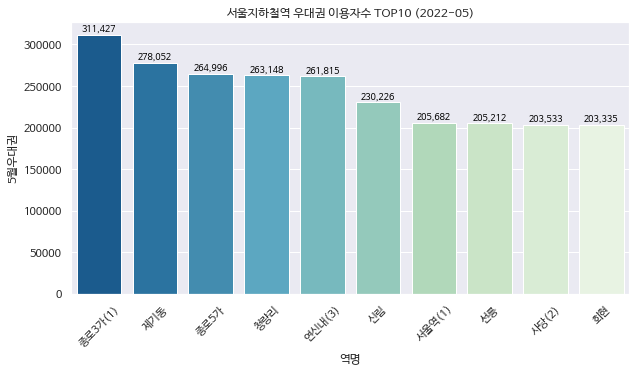

In [ ]:
discount_top10=(discount[['역명','5월우대권']]
    .sort_values('5월우대권',ascending=False)
    .reset_index(drop=True)
    .iloc[:10]
    )
sns.set(rc={"figure.figsize":(10, 5)})
plt.rc('font', family='NanumBarunGothic')
palette = sns.color_palette("GnBu",n_colors=10)
palette.reverse() 
x=discount_top10['역명']
y=discount_top10['5월우대권']
sns.barplot(x=x,y=y,palette=palette).set(title='서울지하철역 우대권 이용자수 TOP10 (2022-05)')
#텍스트 회전
plt.xticks(rotation=45)
#수치값 표시
for i, v in enumerate(discount_top10.index):
    plt.text(v, y[i],'{:,.0f}'.format(y[i]),                
             fontsize = 9, 
             color='black',
             horizontalalignment='center', 
             verticalalignment='bottom')

plt.show()

####서울시 지하철 우대권 승객 비율 상위 10개역

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


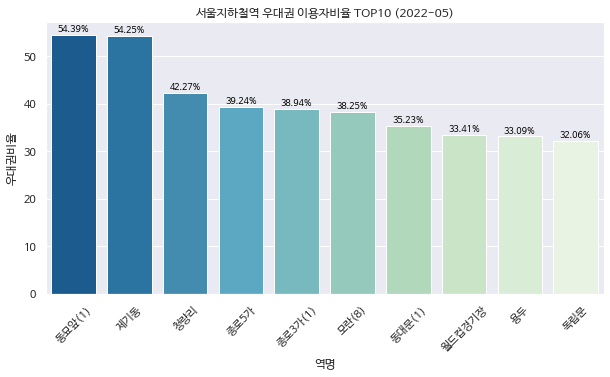

In [ ]:
discount_ratio=discount[['역명']]
discount_ratio['우대권비율']=(discount['5월우대권']/(discount['5월선불']+discount['5월후불']+discount['5월정기권']+discount['5월우대권']+discount['5월1회권']+discount['5월단체권']))*100
discount_ratio=(discount_ratio
                .sort_values('우대권비율',ascending=False)
                .reset_index(drop=True)
                .iloc[:10]
                )
sns.set(rc={"figure.figsize":(10, 5)})
plt.rc('font', family='NanumBarunGothic')
palette = sns.color_palette("GnBu",n_colors=10)
palette.reverse() 
x=discount_ratio['역명']
y=discount_ratio['우대권비율']
sns.barplot(x=x,y=y,palette=palette).set(title='서울지하철역 우대권 이용자비율 TOP10 (2022-05)')
#텍스트 회전
plt.xticks(rotation=45)
#수치값 표시
for i, v in enumerate(discount_ratio.index):
    plt.text(v, y[i], '{:,.2f}%'.format(y[i]),                
             fontsize = 9, 
             color='black',
             horizontalalignment='center', 
             verticalalignment='bottom')

plt.show()

###3. 서울시 대중교통 환승 이용패턴 분석

In [ ]:
#2021.11.30~2022.09.22 목적통행_패턴
df=pd.read_csv('/content/drive/MyDrive/DACON6/지하철 이용 정보/서울시 대중교통 이용패턴 정보.csv',encoding='cp949')

In [ ]:
#목적통행_패턴 기준으로 합침
pattern=df.drop(columns=['기준_날짜'])
pattern=pattern.groupby(df['목적통행_패턴']).sum() 
pattern.reset_index(level=['목적통행_패턴'], inplace = True)

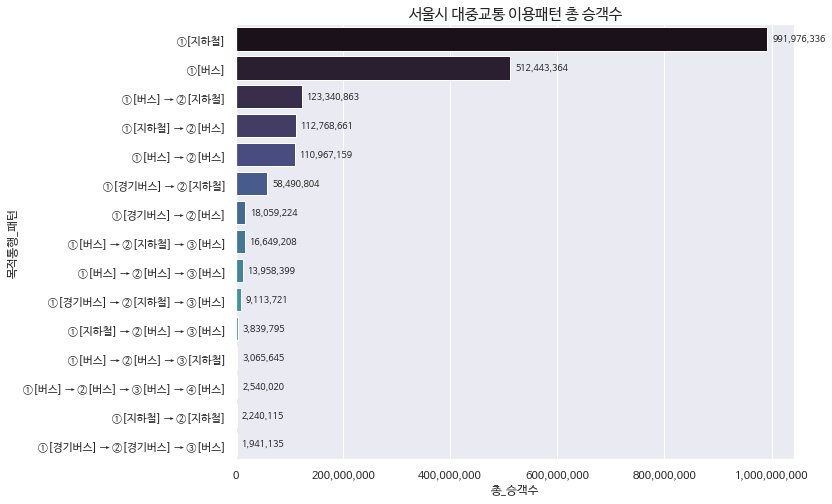

In [ ]:
#목적통행_패턴 총 승객수 top15
pattern_total=(pattern[['목적통행_패턴','총_승객수']]
                .sort_values('총_승객수',ascending=False)
                .reset_index(drop=True)
                .iloc[:15]
                )
sns.set(rc={"figure.figsize":(10, 8)})
plt.rc('font', family='NanumBarunGothic') 
x=pattern_total['총_승객수']
y=pattern_total['목적통행_패턴']
ax=sns.barplot(x=x,y=y,palette="mako",data=pattern_total,orient='h')
ax.set_title('서울시 대중교통 이용패턴 총 승객수',fontsize=15)
#수치값 표시
for p in ax.patches:
    ax.annotate('{:,.0f}'.format(p.get_width()), (p.get_x() + p.get_width(), p.get_y() + 0.8),fontsize=9,
                xytext=(5, 10), textcoords='offset points')
current_values = plt.gca().get_xticks()
plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values]) 
plt.show()

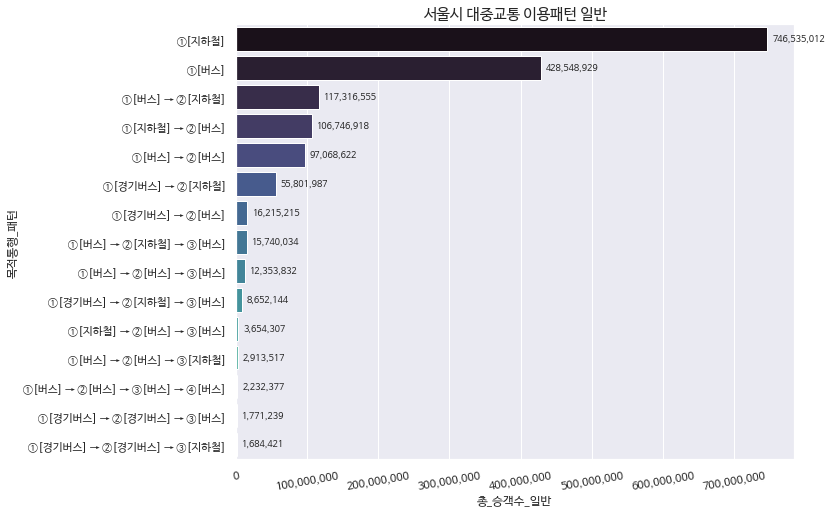

In [ ]:
#목적통행_패턴 일반 승객수 top15
pattern_regular=(pattern[['목적통행_패턴','총_승객수_일반']]
                .sort_values('총_승객수_일반',ascending=False)
                .reset_index(drop=True)
                .iloc[:15]
                )
pattern_regular['총_승객수_일반']=pattern_regular['총_승객수_일반'].astype(int)   
sns.set(rc={"figure.figsize":(10, 8)})
plt.rc('font', family='NanumBarunGothic') 
x=pattern_regular['총_승객수_일반']
y=pattern_regular['목적통행_패턴']
ax=sns.barplot(x=x,y=y,palette="mako",data=pattern_regular,orient='h')
ax.set_title('서울시 대중교통 이용패턴 일반',fontsize=15)
# 수치값 표시
for p in ax.patches:
    ax.annotate('{:,.0f}'.format(p.get_width()), (p.get_x() + p.get_width(), p.get_y() + 0.8),fontsize=9,
                xytext=(5, 10), textcoords='offset points')
current_values = plt.gca().get_xticks()
plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])
#텍스트 회전
plt.xticks(rotation=10) 
plt.show()

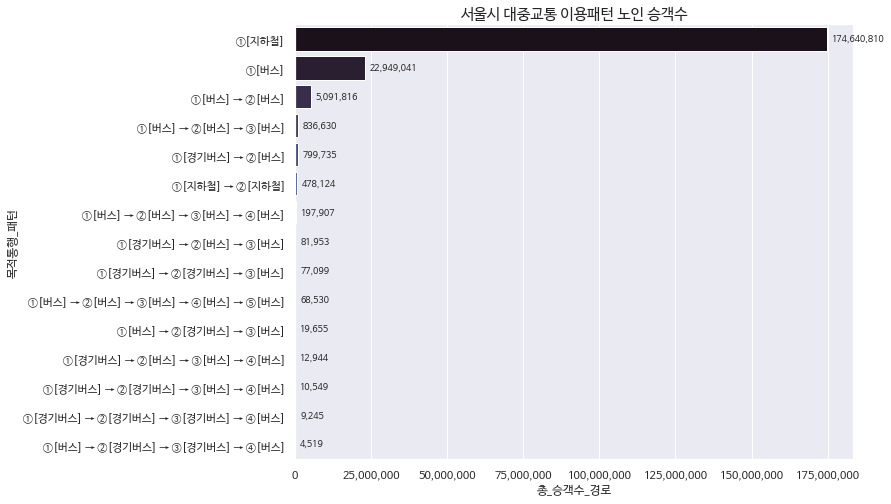

In [ ]:
#목적통행_패턴 노인 승객수 top15
pattern_senior=(pattern[['목적통행_패턴','총_승객수_경로']]
                .sort_values('총_승객수_경로',ascending=False)
                .reset_index(drop=True)
                .iloc[:15]
                )
pattern_senior['총_승객수_경로']=pattern_senior['총_승객수_경로'].astype(int) 
sns.set(rc={"figure.figsize":(10, 8)})
plt.rc('font', family='NanumBarunGothic') 
x=pattern_senior['총_승객수_경로']
y=pattern_senior['목적통행_패턴']
ax=sns.barplot(x=x,y=y,palette="mako",data=pattern_senior,orient='h')
ax.set_title('서울시 대중교통 이용패턴 노인 승객수',fontsize=15)
# 수치값 표시
for p in ax.patches:
    ax.annotate('{:,.0f}'.format(p.get_width()), (p.get_x() + p.get_width(), p.get_y() + 0.8),fontsize=9,
                xytext=(5, 10), textcoords='offset points')
current_values = plt.gca().get_xticks()
plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values]) 

plt.show()

# References

###### <a>[[1]](https://www.etoday.co.kr/news/view/2171664)</a>: 이재훈, 박지훈, 박진호, 전병관, 최의평, 박정수.(2016).철도 무임승차 제도의 문제점과 해결방안 모색.한국철도학회 학술발표대회논문집,(),701.
###### <a>[[2]](https://www.etoday.co.kr/news/view/2171664)</a>: 이창훈, 김시곤, 윤경철.(2016).수도권 교통카드자료를 활용한 무임승차제도의 탄력적 운영방안.대한토목학회논문집,36(6),1069-1073.
###### <a>[[3]](https://www.etoday.co.kr/news/view/2171664)</a>: 정대한. (2022년09월12일). 도시철도 무임승차로 지난해 4717억 원 손실…"국고 지원 필요". 이투데이. pp.All
###### <a>[[4]](https://www.etoday.co.kr/news/view/2171664)</a>: 신성일.(2022).지속 가능한 무임승차제도 위해 서울교통공사에 정부 지원 검토해야.월간 공공정책,197(),62.
###### <a>[[5]](https://www.etoday.co.kr/news/view/2171664)</a>: 최진석.(2019).지하철 경로무임승차 논란의 근본적 해결방안.교통기술과정책,16(4),43-48.
###### <a>[[6]](https://www.etoday.co.kr/news/view/2171664)</a>: 석재은, 김용하 and 임정기. (2015). 노인의 이동성 지원과 지하철 무료이용제도 개선방안. 노인복지연구, 69, 291-322.
###### <a>[[7]](http://dl.nanet.go.kr/law/SearchDetailView.do?cn=NONB1201420898)</a>: 석재은. (2013). 노인교통이용요금제도 개선방안 연구: 지하철 무임승차를 중심으로. 보건복지부. http://dl.nanet.go.kr/law/SearchDetailView.do?cn=NONB1201420898.
